### Dynamic Rainfall Prediction via Long-Range Sequence Features (ML-only)

- Dataset: Kaggle WeatherAUS (local CSV)
- Task: Binary classification to predict RainTomorrow (Yes/No)
- Models: Majority baseline, Logistic Regression, Random Forest
- “Long-range sequence” handled via lag/rolling features per Location (no deep learning)
- Deliverables: Metrics table, confusion matrices, ROC curve, feature importances, comparison chart, prediction samples, findings


In [4]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)




In [5]:
RANDOM_STATE = 42
CSV_PATH = r"C:\Users\gauta\Downloads\Machine Learning\ML_Project\weatherAUS.csv"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head(3))
print("\nMissingness (top 15):")
display(df.isna().mean().sort_values(ascending=False).head(15))
print("\nRainTomorrow value counts (raw):")
print(df["RainTomorrow"].value_counts(dropna=False))


Shape: (145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No



Missingness (top 15):


Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
dtype: float64


RainTomorrow value counts (raw):
RainTomorrow
No     110316
Yes     31877
NaN      3267
Name: count, dtype: int64


In [6]:
# Parse date, sort, drop missing target, encode target
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df[df["Date"].notna()]
df = df.sort_values(["Location", "Date"])  # groupwise chronological order

df = df[df["RainTomorrow"].notna()].copy()
df["RainTomorrow"] = (
    df["RainTomorrow"].astype(str).str.strip().str.lower().eq("yes")
).astype(int)

# Cast categorical columns
for c in ["Location","WindGustDir","WindDir9am","WindDir3pm","RainToday"]:
    if c in df.columns:
        df[c] = df[c].astype("category")

# Create numeric flag for RainToday for lag/rolling
if "RainToday" in df.columns:
    df["RainToday_flag"] = (
        df["RainToday"].astype(str).str.strip().str.lower().eq("yes")
    ).astype(float)

# Coerce commonly-used numeric columns to numeric dtype
for c in [
    "Rainfall","Humidity3pm","Temp3pm","WindGustSpeed","MinTemp","MaxTemp",
    "Humidity9am","Temp9am","Pressure9am","Pressure3pm","Cloud9am","Cloud3pm",
    "Evaporation","Sunshine","WindSpeed9am","WindSpeed3pm"
]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("After cleaning shape:", df.shape)
print("Class balance (1=rain):")
print(df["RainTomorrow"].value_counts(normalize=True).round(3))


After cleaning shape: (142193, 24)
Class balance (1=rain):
RainTomorrow
0    0.776
1    0.224
Name: proportion, dtype: float64


In [7]:
# Lag and rolling features per Location (numeric only)
lag_source_cols = [c for c in ["Rainfall","RainToday_flag","Humidity3pm","Temp3pm","WindGustSpeed"] if c in df.columns]
for col in lag_source_cols:
    df[f"{col}_lag1"] = df.groupby("Location")[col].shift(1)
    df[f"{col}_lag2"] = df.groupby("Location")[col].shift(2)
    df[f"{col}_lag3"] = df.groupby("Location")[col].shift(3)
    df[f"{col}_roll3_mean"] = (
        df.groupby("Location")[col]
          .apply(lambda s: s.shift(1).rolling(window=3).mean())
          .reset_index(level=0, drop=True)
    )

req_cols = [f"{c}_lag1" for c in lag_source_cols]
df = df.dropna(subset=req_cols)
print("After feature engineering shape:", df.shape)


C:\Users\gauta\AppData\Local\Temp\ipykernel_20984\3570396158.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"{col}_lag1"] = df.groupby("Location")[col].shift(1)
C:\Users\gauta\AppData\Local\Temp\ipykernel_20984\3570396158.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f"{col}_lag2"] = df.groupby("Location")[col].shift(2)
C:\Users\gauta\AppData\Local\Temp\ipykernel_20984\3570396158.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

After feature engineering shape: (129807, 44)


In [8]:
# Override: pure 80/20 train/test split (no separate validation)
chosen_q_train = None
for qt in [0.80, 0.78, 0.82]:  # try nearby cutoffs if a class is missing
    train_end = df["Date"].quantile(qt)
    train_df = df[df["Date"] <= train_end]
    test_df = df[df["Date"] > train_end]
    if train_df["RainTomorrow"].nunique()==2 and test_df["RainTomorrow"].nunique()==2:
        chosen_q_train = qt
        break
if chosen_q_train is None:
    train_end = df["Date"].quantile(0.90)
    train_df = df[df["Date"] <= train_end]
    test_df = df[df["Date"] > train_end]

# Build matrices
target = "RainTomorrow"
drop_cols = ["Date", target]
features_all = [c for c in df.columns if c not in drop_cols]

X_train, y_train = train_df[features_all], train_df[target]
X_test,  y_test  = test_df[features_all],  test_df[target]

# For downstream cells that expect X_val/y_val, reuse test set (no separate validation)
X_val, y_val = X_test, y_test

print("Split sizes (train/test):", len(X_train), len(X_test))


Split sizes (train/test): 103869 25938


In [9]:
# Preprocessing pipelines
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features),
])

len(numeric_features), len(categorical_features)


(37, 5)

In [10]:
# Baseline (majority class)
majority_class = int(y_train.mode()[0])

def compute_metrics(y_true, y_prob_or_pred, is_prob=True, threshold=0.5):
    if is_prob:
        y_pred = (y_prob_or_pred >= threshold).astype(int)
    else:
        y_pred = y_prob_or_pred
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    roc = np.nan
    if is_prob:
        try:
            roc = roc_auc_score(y_true, y_prob_or_pred)
        except ValueError:
            roc = np.nan
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC_AUC": roc}

y_val_pred_base  = np.full_like(y_val,  fill_value=majority_class)
y_test_pred_base = np.full_like(y_test, fill_value=majority_class)

base_val_metrics  = compute_metrics(y_val,  y_val_pred_base,  is_prob=False)
base_test_metrics = compute_metrics(y_test, y_test_pred_base, is_prob=False)
print("Baseline (test):", base_test_metrics)


Baseline (test): {'Accuracy': 0.779204256303493, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'ROC_AUC': nan}


In [11]:
# Logistic Regression (tune C on validation)
lr = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)),
])

C_grid = [0.1, 1.0, 3.0, 10.0]
best_lr, best_lr_val_f1 = None, -1.0

for C in C_grid:
    lr.set_params(clf__C=C)
    lr.fit(X_train, y_train)
    val_prob = lr.predict_proba(X_val)[:, 1]
    m = compute_metrics(y_val, val_prob, is_prob=True)
    if m["F1"] > best_lr_val_f1:
        best_lr_val_f1 = m["F1"]
        best_lr = lr

print("Best LR val F1:", round(best_lr_val_f1, 4))


Best LR val F1: 0.6315


In [12]:
# Random Forest (small grid on val)
rf = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)),
])

rf_grid = [
    {"clf__n_estimators": 300, "clf__max_depth": None, "clf__max_features": "sqrt"},
    {"clf__n_estimators": 500, "clf__max_depth": 20,   "clf__max_features": "sqrt"},
    {"clf__n_estimators": 500, "clf__max_depth": None, "clf__max_features": "log2"},
]

best_rf, best_rf_val_f1 = None, -1.0

for params in rf_grid:
    rf.set_params(**params)
    rf.fit(X_train, y_train)
    val_prob = rf.predict_proba(X_val)[:, 1]
    m = compute_metrics(y_val, val_prob, is_prob=True)
    if m["F1"] > best_rf_val_f1:
        best_rf_val_f1 = m["F1"]
        best_rf = rf

print("Best RF val F1:", round(best_rf_val_f1, 4))


Best RF val F1: 0.62


In [13]:
# Test-set evaluation and comparison table
results = []

# Baseline
results.append(("Baseline", base_test_metrics))

# Logistic Regression
y_lr_prob = best_lr.predict_proba(X_test)[:, 1]
lr_test_metrics = compute_metrics(y_test, y_lr_prob, is_prob=True)
results.append(("LogisticRegression", lr_test_metrics))

# Random Forest
y_rf_prob = best_rf.predict_proba(X_test)[:, 1]
rf_test_metrics = compute_metrics(y_test, y_rf_prob, is_prob=True)
results.append(("RandomForest", rf_test_metrics))

cmp = pd.DataFrame([{"Model": m, **met} for m, met in results]).set_index("Model")
display(cmp.round(4))


,Accuracy,Precision,Recall,F1,ROC_AUC
Model,,,,,
Baseline,0.7792,0.0000,0.0000,0.0000,NaN
LogisticRegression,0.8010,0.5341,0.7718,0.6313,0.8719
RandomForest,0.8451,0.7635,0.4323,0.5521,0.8710


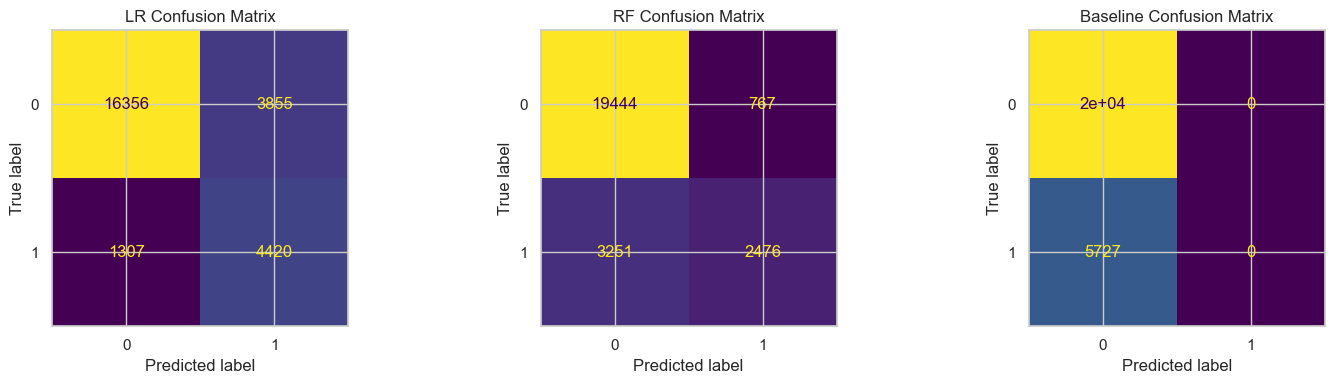

<Figure size 700x500 with 0 Axes>

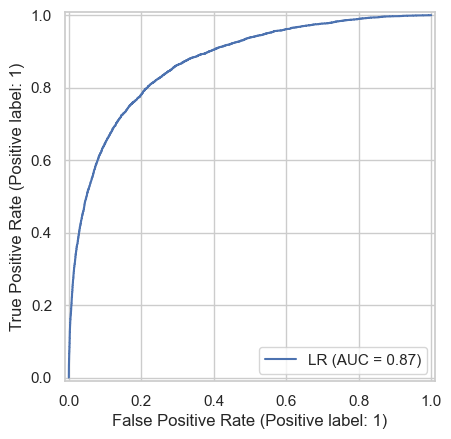

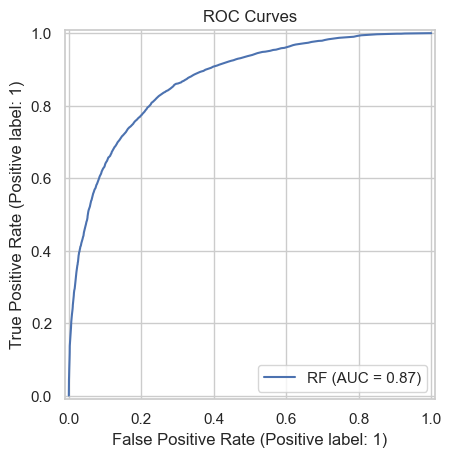

In [14]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ConfusionMatrixDisplay.from_predictions(y_test, (y_lr_prob >= 0.5).astype(int), ax=axes[0], colorbar=False)
axes[0].set_title("LR Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, (y_rf_prob >= 0.5).astype(int), ax=axes[1], colorbar=False)
axes[1].set_title("RF Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, np.full_like(y_test, fill_value=majority_class), ax=axes[2], colorbar=False)
axes[2].set_title("Baseline Confusion Matrix")
plt.tight_layout(); plt.show()

# ROC curves
plt.figure(figsize=(7,5))
RocCurveDisplay.from_predictions(y_test, y_lr_prob, name="LR")
RocCurveDisplay.from_predictions(y_test, y_rf_prob, name="RF")
plt.title("ROC Curves"); plt.show()


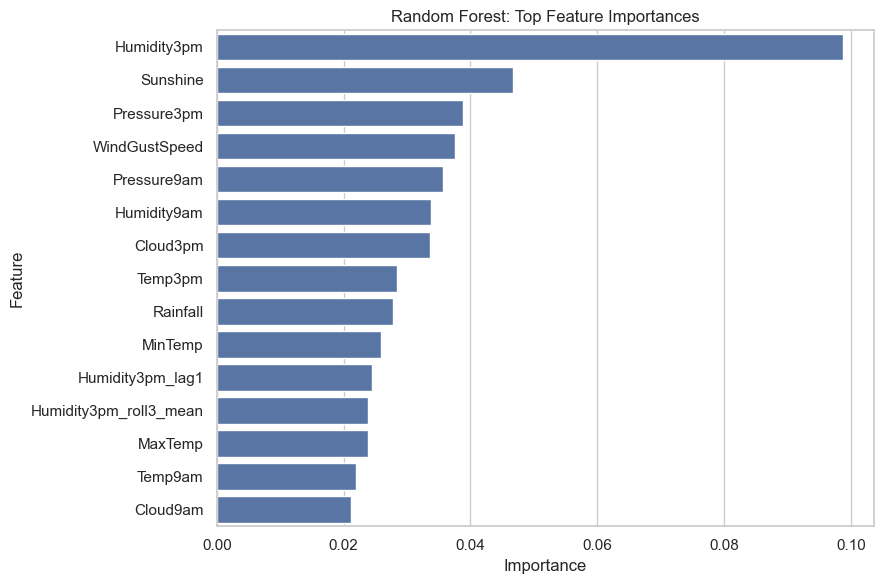

,Top Positive,Top Negative
Humidity3pm,1.346221,NaN
Pressure9am,0.959081,NaN
WindGustSpeed,0.827226,NaN
Location_PearceRAAF,0.536047,NaN
Location_Williamtown,0.516692,NaN
Location_Adelaide,0.514038,NaN
Location_Witchcliffe,0.492305,NaN
Location_Perth,0.419659,NaN
Temp3pm,0.401541,NaN
Location_Albury,0.395190,NaN


In [15]:
# Feature importance (RF) and LR coefficients
pre_fitted = best_rf.named_steps["preprocess"]
ohe = pre_fitted.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + cat_names

# RF importances
rf_model = best_rf.named_steps["clf"]
rf_importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)
top_imp = rf_importances.head(15)
plt.figure(figsize=(9,6))
sns.barplot(x=top_imp.values, y=top_imp.index, orient="h")
plt.title("Random Forest: Top Feature Importances")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

# LR coefficients
lr_model = best_lr.named_steps["clf"]
lr_coef = pd.Series(lr_model.coef_[0], index=feature_names).sort_values(ascending=False)
display(pd.concat([lr_coef.head(10).rename("Top Positive"), lr_coef.tail(10).rename("Top Negative")], axis=1))


<Figure size 800x500 with 0 Axes>

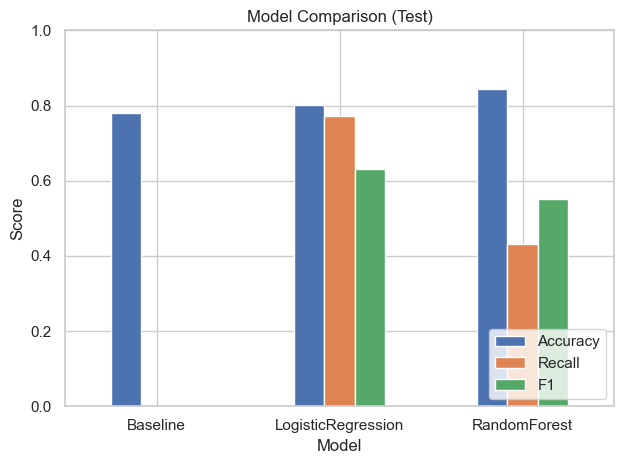

In [16]:
# Comparison bar chart
plt.figure(figsize=(8,5))
cmp[["Accuracy","Recall","F1"]].plot(kind="bar")
plt.title("Model Comparison (Test)")
plt.ylabel("Score"); plt.ylim(0,1); plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout(); plt.show()


In [17]:
# Prediction samples (first 10)
sample_n = 10
sample = X_test.head(sample_n).copy()
sample = sample.assign(
    y_true = y_test.head(sample_n).values,
    LR_prob = y_lr_prob[:sample_n],
    RF_prob = y_rf_prob[:sample_n]
)
sample["LR_pred"] = (sample["LR_prob"] >= 0.5).astype(int)
sample["RF_pred"] = (sample["RF_prob"] >= 0.5).astype(int)

cols_to_show = ["y_true","LR_prob","LR_pred","RF_prob","RF_pred"]
for c in ["Location","Rainfall","Humidity3pm","Temp3pm"]:
    if c in sample.columns:
        cols_to_show.append(c)

display(sample[cols_to_show])


,y_true,LR_prob,LR_pred,RF_prob,RF_pred,Location,Rainfall,Humidity3pm,Temp3pm
98918,0,0.354354,0,0.128,0,Adelaide,0.0,18.0,36.5
98919,0,0.552737,1,0.144,0,Adelaide,0.2,47.0,24.4
98920,0,0.079192,0,0.056,0,Adelaide,0.0,37.0,25.9
98921,0,0.214743,0,0.046,0,Adelaide,0.0,42.0,25.5
98922,0,0.145995,0,0.052,0,Adelaide,0.0,42.0,20.3
98923,0,0.223955,0,0.054,0,Adelaide,0.0,52.0,20.7
98924,0,0.122160,0,0.034,0,Adelaide,0.0,31.0,23.6
98925,0,0.073724,0,0.030,0,Adelaide,0.0,19.0,30.4
98926,0,0.071540,0,0.046,0,Adelaide,0.0,14.0,35.1
98927,0,0.221031,0,0.056,0,Adelaide,0.0,12.0,39.4


### Findings and Discussion

- Key metrics (test): See table (Accuracy, Precision, Recall, F1, ROC AUC).
- ROC: Curves show discrimination; RF often higher AUC if nonlinear signals exist.
- Feature importance: RF highlights influential variables and lag/rolling effects.
- Class imbalance: Balanced class weights used; evaluate Recall/F1, not only Accuracy.

#### Strengths
- Time-aware split avoids leakage.
- Lag/rolling features introduce “long-range” information without deep learning.
- Clear pipelines and comparability across models.

#### Limitations
- Stationarity assumptions; weather patterns can shift over time.
- Missing data and categorical cardinality may reduce signal.
- Single global model across all locations may miss regional nuances.

#### Future Work
- Tune thresholds for different precision/recall trade-offs.
- Add more temporal aggregates (7/14-day windows).
- Train per-region models or add interaction features.
